In [2]:
%pylab inline
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
from IPython.display import clear_output
import time
#from time import sleep
import numpy as np
import math
import gym

Populating the interactive namespace from numpy and matplotlib


In [3]:
#from myfrozen import frozen_lake
import myfrozen

In [20]:
from gym.envs.registration import register, spec

MY_ENV_NAME='FrozenLakeNonskid8x8-v2'
register(
        id=MY_ENV_NAME,
        entry_point='myfrozen.frozen_lake:FrozenLakeEnv',
        kwargs={'map_name': '8x8', 'is_slippery': False},
        timestep_limit=100,
        reward_threshold=0.78, # optimum = .8196
)

env = gym.make(MY_ENV_NAME)

In [5]:
def to_onehot(size,value):
  my_onehot = np.zeros((size))
  my_onehot[value] = 1.0
  return my_onehot

OBSERVATION_SPACE = env.observation_space.n
ACTION_SPACE = env.action_space.n

# Assume gridworld is always square
OBS_SQR = int(math.sqrt(OBSERVATION_SPACE))
STATEGRID = np.zeros((OBS_SQR,OBS_SQR))

## Plotting 

In [8]:
#collect = []
def run_episode(env,Q,learning_rate,gamma,episode,zerostates):
    observation = env.reset()
    done = False
    t_reward = 0
    max_steps = 100
    #max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
    move_counter = 0
    for j in range(max_steps):
        if done:
            if j < max_steps:
                zerostates.add(observation)
            break

        curr_state = observation

        #action = np.argmax(Q[curr_state,:]  + np.random.randn(1, env.action_space.n)*(1./(episode+1)))
        action = np.argmax(Q[curr_state,:]  + np.random.randn(1, env.action_space.n))
        
        move_counter+=1
        
        observation, reward, done, info = env.step(action)
        
        collect.append((curr_state,action,observation,reward))

        t_reward += reward

        #Q(state, action) = R(state, action) + Gamma * Max[Q(next state, all actions)]
        Q[curr_state,action] += learning_rate * (reward+ gamma*np.max(Q[observation,:])-Q[curr_state,action])

    return Q, t_reward, done, move_counter

In [9]:
collect = []
zerostates = set()
def trainer(epochs=1000,learning_rate = 0.81,discount = 0.96):

    reward_per_ep = list()
    wins = 0
    losses = 0
    
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    for i in range(epochs):
        #print i
        Q, t_reward, done, move_counter = run_episode(env,Q,learning_rate,discount,i,zerostates)
        #print done
        reward_per_ep.append(t_reward)

        if done:
            if t_reward > 0 : # Win
                wins += 1
            else: # Loss
                losses += 1
        time.sleep(.1)        
        clear_output(wait=True)
        print("Game #: %s" % (i+1,))
        print("Moves this round %s" % move_counter)
        print("Final Position:")
        env.render()
        print("Wins/Losses %s/%s" % (wins, losses))
    return Q, reward_per_ep, collect, zerostates

In [21]:
%%time
q, rpe, collect, zerostates = trainer(epochs=2000)

Game #: 2000
Moves this round 1
Final Position:
  (Down)
FFFFFFSF
FFFFFFHF
FHFFFFFF
FFFFFHFF
FFHFFFFF
FHFFFFFF
FFFHFFFF
FFFFFGFF
Wins/Losses 182/1818
CPU times: user 13.9 s, sys: 2.98 s, total: 16.9 s
Wall time: 3min 39s


In [23]:
collect = np.array(collect)
import pandas as pd
df = pd.DataFrame(data=collect, columns=['state','action','state_new','reward'])

In [24]:
one_hot = pd.get_dummies(df['state'],prefix='state')
df = df.drop('state',axis=1)
df = df.join(one_hot)
one_hot = pd.get_dummies(df['state_new'],prefix='new_state')
df = df.drop('state_new',axis=1)
df = df.join(one_hot)
one_hot = pd.get_dummies(df['action'],prefix='action')
df = df.drop('action',axis=1)
df = df.join(one_hot)

In [46]:
zerostates

{13, 20, 27, 36, 45, 49, 58}

In [53]:
list(df.columns.values)

['state_0.0',
 'state_1.0',
 'state_2.0',
 'state_3.0',
 'state_4.0',
 'state_5.0',
 'state_6.0',
 'state_7.0',
 'state_8.0',
 'state_9.0',
 'state_10.0',
 'state_11.0',
 'state_12.0',
 'state_14.0',
 'state_15.0',
 'state_16.0',
 'state_17.0',
 'state_18.0',
 'state_19.0',
 'state_21.0',
 'state_22.0',
 'state_23.0',
 'state_24.0',
 'state_25.0',
 'state_26.0',
 'state_28.0',
 'state_29.0',
 'state_30.0',
 'state_31.0',
 'state_32.0',
 'state_33.0',
 'state_34.0',
 'state_35.0',
 'state_37.0',
 'state_38.0',
 'state_39.0',
 'state_40.0',
 'state_41.0',
 'state_42.0',
 'state_43.0',
 'state_44.0',
 'state_46.0',
 'state_47.0',
 'state_48.0',
 'state_50.0',
 'state_51.0',
 'state_52.0',
 'state_53.0',
 'state_54.0',
 'state_55.0',
 'state_56.0',
 'state_57.0',
 'state_59.0',
 'state_60.0',
 'state_61.0',
 'state_62.0',
 'state_63.0',
 'new_state_0.0',
 'new_state_1.0',
 'new_state_2.0',
 'new_state_3.0',
 'new_state_4.0',
 'new_state_5.0',
 'new_state_6.0',
 'new_state_7.0',
 'new_state

In [25]:
from sklearn import linear_model
target = pd.DataFrame(df.reward, columns=["reward"])
df = df.drop('reward',axis=1)

In [26]:
lm = linear_model.LinearRegression()
model = lm.fit(df,target['reward'])

### What the Value network has learned


FFFFFFSF
FFFFFFHF
FHFFFFFF
FFFFFHFF
FFHFFFFF
FHFFFFFF
FFFHFFFF
FFFFFGFF


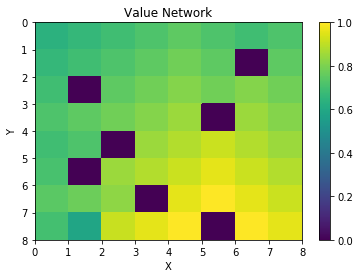

In [22]:
# Plot out the values the critic gives for the agent being in
# a specific state, i.e. in a specific location in the env.
def plot_value(initial_state):
    # Assume gridworld is always a square
    obs_sqr = math.sqrt(OBSERVATION_SPACE)
    np_w_cri_r = np.zeros((OBS_SQR,OBS_SQR))
    # make a working copy.
    working_state = initial_state.copy()
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y] = 1
            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            value = np.max(q[index,:])
            #value = 0
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()

env.reset()
env.render()
plot_value(STATEGRID)

In [12]:
np.argmax(q,axis=1)

array([2, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       3, 3, 1, 0, 2, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 2, 3, 2, 1, 0, 0, 3, 0, 3, 3, 3, 0, 3, 0, 0, 2, 2, 3])

map shape: (8, 8), data type: float64


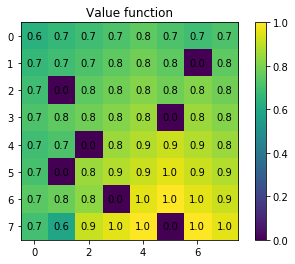

In [23]:
import img_utils
#reload(img_utils)
figure = img_utils.heatmap2d(np.reshape(np.max(q,axis=1), (8, 8), order='C'), 'Value function')

In [34]:
type(figure)
#fig.savefig("images/%d.png" % epoch)

NoneType

In [32]:
def compute_reward(s,new_s,a):
    s = to_onehot(OBSERVATION_SPACE,s)
    new_s = to_onehot(OBSERVATION_SPACE,new_s)
    a = to_onehot(ACTION_SPACE,a)
    vectorized = np.hstack((s,new_s,a))
    index = list(zerostates)
    vectorized = np.delete(vectorized, index)
    return np.dot(model.coef_,vectorized)

In [33]:
tofill = np.zeros((OBSERVATION_SPACE,OBSERVATION_SPACE,ACTION_SPACE))
env.reset()
for s in xrange(0,OBSERVATION_SPACE):
    for new_s in xrange(0,OBSERVATION_SPACE):
        for a in xrange(0,ACTION_SPACE):
            tofill[(s,new_s,a)] = compute_reward(s,new_s,a)
            
sub = tofill[0, :, :]
sub = np.max(sub,axis=1)
#np.argmax(np.max(sub,axis=1))

In [35]:
sub = tofill[0, :, :]
sub = np.min(sub,axis=1)

map shape: (8, 8), data type: float64


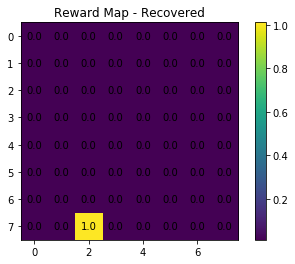

In [36]:
import img_utils
img_utils.heatmap2d(np.reshape(sub, (8, 8), order='C'), 'Reward Map - Recovered')

In [45]:
model.coef_

array([0.00526674, 0.00526674, 0.00526674, 0.00526674, 0.00526674,
       0.00526674, 0.00526674, 0.00526674, 0.00526674, 0.00526674,
       0.00526674, 0.00526674, 0.00526674, 0.00526674, 0.00526674,
       0.00526674, 0.00526674, 0.00526674, 0.00526674, 0.00526674,
       0.00526674, 0.00526674, 0.00526674, 0.00526674, 0.00526674,
       0.00526674, 0.00526674, 0.00526674, 0.00526674, 0.00526674,
       0.00526674, 0.00526674, 0.00526674, 0.00526674, 0.00526674,
       0.00526674, 0.00526674, 0.00526674, 0.00526674, 0.00526674,
       0.00526674, 0.00526674, 0.00526674, 0.00526674, 0.00526674,
       0.00526674, 0.00526674, 0.00526674, 0.00526674, 0.00526674,
       0.00526674, 0.00526674, 0.00526674, 0.00526674, 0.00526674,
       0.00526674, 0.00526674, 0.00221781, 0.00221781, 0.00221781,
       0.00221781, 0.00221781, 0.00221781, 0.00221781, 0.00221781,
       0.00221781, 0.00221781, 0.00221781, 0.00221781, 0.00221781,
       0.00221781, 0.00221781, 0.00221781, 0.00221781, 0.00221

# RECOVER REWARD BY LINEAR REGRESSION

In [13]:
def compute_reward(s,new_s,a):
    s = to_onehot(OBSERVATION_SPACE,s)
    new_s = to_onehot(OBSERVATION_SPACE,new_s)
    a = to_onehot(ACTION_SPACE,a)
    vectorized = np.hstack((s,new_s,a))
    index = list(zerostates)
    vectorized = np.delete(vectorized, index)
    return np.dot(model.coef_,vectorized)
    
def run_episode(env,Q,learning_rate,gamma,episode):
    observation = env.reset()
    done = False
    t_reward = 0
    max_steps = 100
    #max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
    move_counter = 0
    for j in range(max_steps):
        if done:
            break

        curr_state = observation

        #action = np.argmax(Q[curr_state,:]  + np.random.randn(1, env.action_space.n)*(1./(episode+1)))
        action = np.argmax(Q[curr_state,:]  + np.random.randn(1, env.action_space.n))
        
        move_counter+=1
        
        observation, true_reward, done, info = env.step(action)
        
        reward = compute_reward(curr_state,observation,action)
        
        #collect.append((curr_state,action,observation,reward))

        t_reward += reward

        #Q(state, action) = R(state, action) + Gamma * Max[Q(next state, all actions)]
        Q[curr_state,action] += learning_rate * (reward+ gamma*np.max(Q[observation,:])-Q[curr_state,action])

    return Q, t_reward, done, move_counter, true_reward

In [14]:
def trainer(epochs=1000,learning_rate = 0.81,discount = 0.96):
    #env = gym.make('FrozenLake-v0')
    #env = wrappers.Monitor(env, '/tmp/FrozenLake-experiment-6',force=True)

    reward_per_ep = list()
    wins = 0
    losses = 0
    
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    for i in range(epochs):
        #print i
        Q, t_reward, done, move_counter, true_reward = run_episode(env,Q,learning_rate,discount,i)
        #print done
        reward_per_ep.append(t_reward)

        if done:
            if true_reward > 0 : # Win
                wins += 1
            else: # Loss
                losses += 1
        time.sleep(.1)        
        clear_output(wait=True)
        print("Game #: %s" % (i+1,))
        print("Moves this round %s" % move_counter)
        print("Final Position:")
        env.render()
        print("Wins/Losses %s/%s" % (wins, losses))
    return Q, reward_per_ep

In [15]:
%%time
q, rpe = trainer(epochs=2000)

Game #: 2000
Moves this round 7
Final Position:
  (Right)
FFFFFSFF
FFFFHFFF
FFFFFFFH
FFFFFFHF
FFFFFHFF
FFHFFFFF
FFFFFFHF
FFFFGFFF
Wins/Losses 72/1928
CPU times: user 17.2 s, sys: 10.9 s, total: 28.1 s
Wall time: 3min 44s


### What the Value network has learned


FFFFSFFF
FFFFFHFF
FFFFHFFF
FFFHFFFF
FFFFHFFF
FFFFFHFF
FHFFFFFF
FFGFFFFF


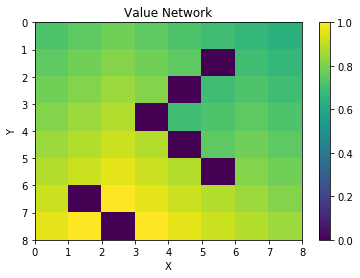

In [54]:
# Plot out the values the critic gives for the agent being in
# a specific state, i.e. in a specific location in the env.
def plot_value(initial_state):
    # Assume gridworld is always a square
    obs_sqr = math.sqrt(OBSERVATION_SPACE)
    np_w_cri_r = np.zeros((OBS_SQR,OBS_SQR))
    # make a working copy.
    working_state = initial_state.copy()
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y] = 1
            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            value = np.max(q[index,:])
            #value = 0
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()

env.reset()
env.render()
plot_value(STATEGRID)

### Showing Policy

In [36]:
A2A=['<','v','>','^']
def show_policy(initial_state):
    grid = np.zeros((OBS_SQR,OBS_SQR), dtype='<U2')
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = initial_state.copy()
            my_state[x,y] = 1

            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            action = np.argmax(q[index,:])
            grid[x,y] = A2A[action]
    grid
    return grid

env.reset()
env.render()

grid = show_policy(STATEGRID)
print(grid)


FFFFFFSF
FFFFFFHF
FHFFFFFF
FFFFFHFF
FFHFFFFF
FHFFFFFF
FFFHFFFF
FFFFFGFF
[[u'v' u'v' u'v' u'v' u'v' u'<' u'<' u'v']
 [u'v' u'>' u'v' u'v' u'v' u'<' u'<' u'v']
 [u'v' u'<' u'v' u'v' u'v' u'<' u'v' u'<']
 [u'>' u'>' u'>' u'v' u'v' u'<' u'v' u'<']
 [u'^' u'^' u'<' u'v' u'v' u'v' u'<' u'<']
 [u'v' u'<' u'>' u'>' u'v' u'v' u'<' u'<']
 [u'>' u'>' u'v' u'<' u'>' u'v' u'<' u'<']
 [u'^' u'<' u'>' u'>' u'>' u'<' u'<' u'<']]


In [44]:
A2A=['<','v','>','^']
def show_policy(initial_state):
    grid = np.zeros((OBS_SQR,OBS_SQR), dtype='<U2')
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = initial_state.copy()
            my_state[x,y] = 1

            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            action = np.argmax(q[index,:])
            grid[x,y] = A2A[action]
    grid
    return grid

env.reset()
env.render()

grid = show_policy(STATEGRID)
print(grid)


FFFFFFSF
FFFFFFHF
FHFFFFFF
FFFFFHFF
FFHFFFFF
FHFFFFFF
FFFHFFFF
FFFFFGFF
[[u'v' u'v' u'v' u'v' u'v' u'<' u'<' u'v']
 [u'v' u'>' u'v' u'v' u'v' u'<' u'<' u'v']
 [u'v' u'<' u'v' u'v' u'v' u'<' u'v' u'<']
 [u'>' u'>' u'>' u'v' u'v' u'<' u'v' u'<']
 [u'^' u'^' u'<' u'v' u'v' u'v' u'<' u'<']
 [u'v' u'<' u'>' u'>' u'v' u'v' u'<' u'<']
 [u'>' u'>' u'v' u'<' u'>' u'v' u'<' u'<']
 [u'^' u'<' u'>' u'>' u'>' u'<' u'<' u'<']]


# SAVING

In [31]:
policy = np.zeros(OBSERVATION_SPACE)
for i in range(OBSERVATION_SPACE):
     policy[i] = np.argmax(q[i,:])

In [33]:
D = {}
D["env"] = env
D["q"] = q
D["zerostates"] = zerostates
D["policy"] = policy
D["model"] = model

In [39]:
import pickle 
output = open('saved/test.pkl', 'wb')
pickle.dump(D, output)
output.close()